Pairs Trading is a trading strategy that matches a long position in one stock/asset with an offsetting position in another stock/asset that is statistically related. Pairs Trading can be called a mean reversion strategy where we bet that the prices will revert to their historical trends.

When the spread is 0, no profit is made. When the spread is negative/positive, the long/short direction on each of the 2 assets in the pair will change.

In [1]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from statsmodels.regression.rolling import RollingOLS

import yfinance as yf
import seaborn
import matplotlib.pyplot as plt

In [2]:
symbol_list = ['NVDA', 'DIOD', 'MU', 'MX', 'ON', 'VECO', 'ENTG', 'AMD','ASX', 'FORM', 'DQ', 'CVV']
data = yf.download(
    symbol_list, 
    start='2013-01-01', 
    end='2023-07-07'
)['Adj Close']

[*********************100%***********************]  12 of 12 completed


In [3]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [4]:
scores, pvalues, pairs = find_cointegrated_pairs(data)

<AxesSubplot: >

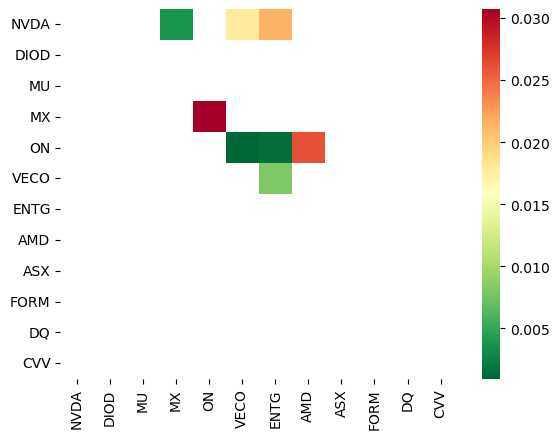

In [5]:
seaborn.heatmap(
    pvalues, 
    xticklabels=symbol_list, 
    yticklabels=symbol_list, 
    cmap='RdYlGn_r', 
    mask = (pvalues >= 0.05)
)


Seems that NVDA and VECO are co-integrated. The next step would be to model the spread.

In [14]:
S1 = data.NVDA
S2 = data.VECO

S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1.NVDA
b = results.params['NVDA']
spread = S2 - b * S1

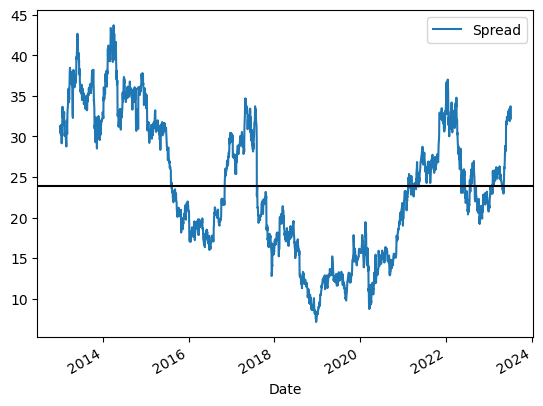

In [15]:
spread.plot()
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread']);

Building a simple trading strategy by setting limits for spread.

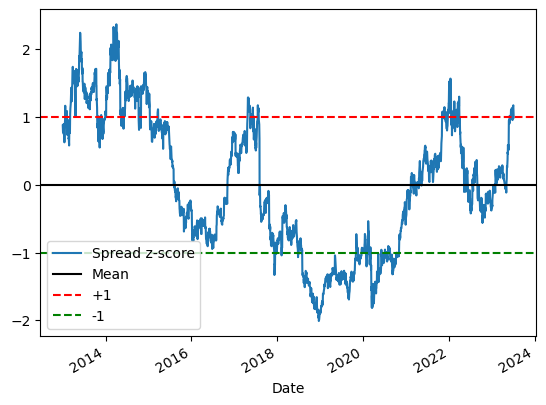

In [16]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);


To determine if this trade is profitable, we construct an equity curve.

In [18]:
# Create a DataFrame with the signal (Z-scores) and position size (Actual spreads) in the pair
trades = pd.concat([zscore(spread), S2 - b * S1], axis=1)
trades.columns = ["signal", "position"]

# Add a long and short position at the z-score levels
trades["side"] = 0.0
trades.loc[trades.signal <= -1, "side"] = 1 # Any trades below signal, long
trades.loc[trades.signal >= 1, "side"] = -1 # Any trades above signal, short
# Any trades  in between signals = HOLD


In [19]:
trades

,signal,position,side
Date,,,
2013-01-02,0.871637,31.224814,0.0
2013-01-03,0.826253,30.844858,0.0
2013-01-04,0.777497,30.436666,0.0
2013-01-07,0.772524,30.395030,0.0
2013-01-08,0.826130,30.843824,0.0
...,...,...,...
2023-06-29,1.107574,33.200113,-1.0
2023-06-30,1.152517,33.576380,-1.0
2023-07-03,1.169325,33.717099,-1.0


<AxesSubplot: xlabel='Date'>

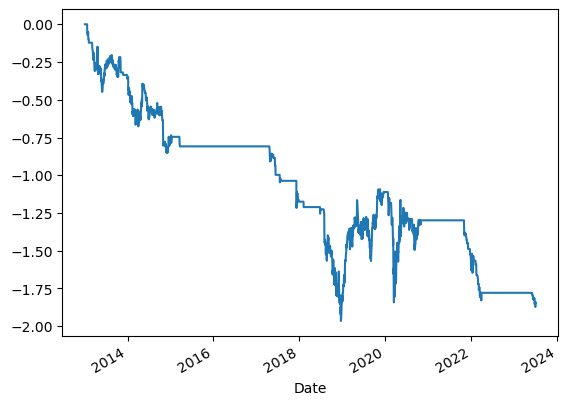

In [20]:
returns = trades.position.pct_change() * trades.side # If % change is positive and you short it, you lose money as short trades profit when % change is negative
returns.cumsum().plot()

This pair is consistently losing money. This could be due to several reasons. First, there is no linear combination that is stationary and we have a false positive. Or, there is no real economic relationship that drives the two stocks. Or, there is a linear combination and there is an economic relationship, but the relationship continued to break down during the frame I used.

Now I'll try ON and AMD because both are semiconductor suppliers.

In [21]:
S1 = data.ON
S2 = data.AMD

S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1.ON
b = results.params['ON']
spread = S2 - b * S1

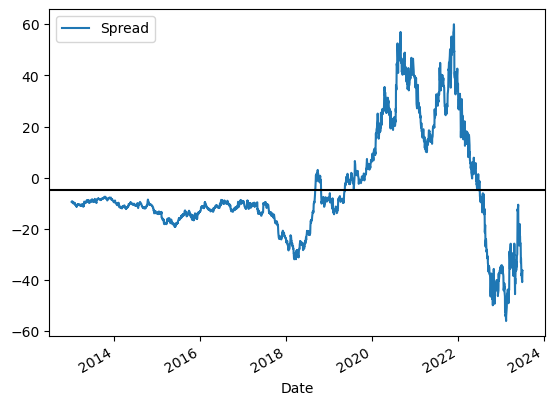

In [22]:
spread.plot()
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread']);

<AxesSubplot: xlabel='Date'>

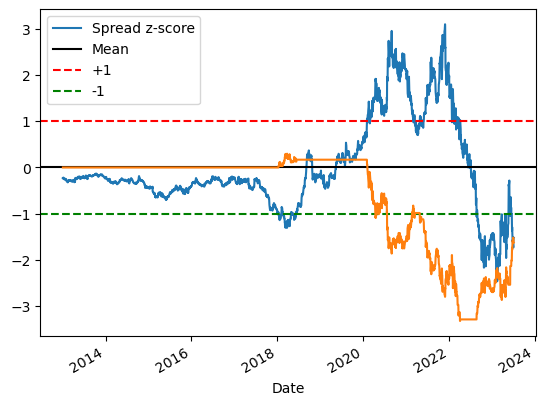

In [23]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);
# Create a DataFrame with the signal (Z-scores) and position size (Actual spreads) in the pair
trades = pd.concat([zscore(spread), S2 - b * S1], axis=1)
trades.columns = ["signal", "position"]

# Add a long and short position at the z-score levels
trades["side"] = 0.0
trades.loc[trades.signal <= -1, "side"] = 1 # Any trades below signal, long
trades.loc[trades.signal >= 1, "side"] = -1 # Any trades above signal, short
# Any trades  in between signals = HOLD
returns = trades.position.pct_change() * trades.side # If % change is positive and you short it, you lose money as short trades profit when % change is negative
returns.cumsum().plot()

Clearly, this strategy is largely not profitable.

I'll move away from AI and semiconductor stocks to currencies and country indexes, especially the USDJPY/Nikkei on the back of the lead up to the BoJ announcement on 28 July 2023. I'm curious what I'll find. I've set the timeframe to start from 2012, when Abenomics set in and quantitative easing took place which weakened the Yen. 

USDJPY / NK : This pair demonstrates a positive correlation between these two assets. Given that Japan is export driven, when JPY strengths against USD (i.e. USDJPY weakens), Nikkei is expected to decline because of lower consumption.

In [69]:
pair_list = ['JPY=X','^N225']
data_1 = yf.download(
    pair_list, 
    start='2012-01-01', 
    end='2023-07-07'
)['Adj Close']

[*********************100%***********************]  2 of 2 completed


In [70]:
data_1=data_1.dropna()

In [71]:
data_1['JPY=X'].corr(data_1['^N225'])

0.7511422747301727

In [72]:
S1 = data_1['JPY=X']
S2 = data_1['^N225']

S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1['JPY=X']
b = results.params['JPY=X']
spread = S2 - b * S1

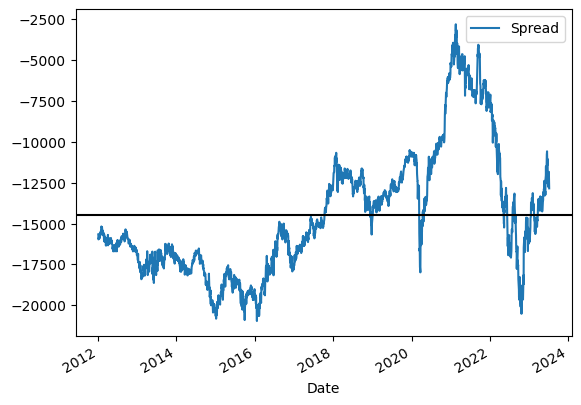

In [73]:
spread.plot()
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread']);

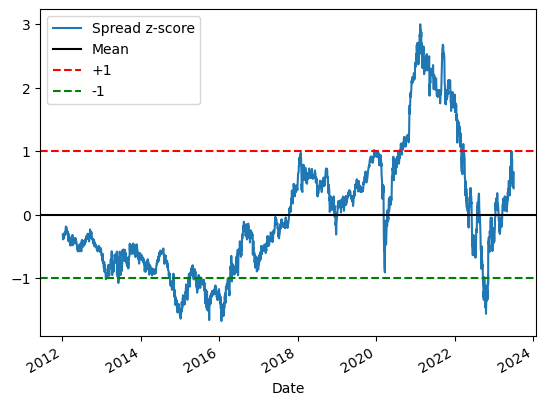

In [74]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);

<AxesSubplot: xlabel='Date'>

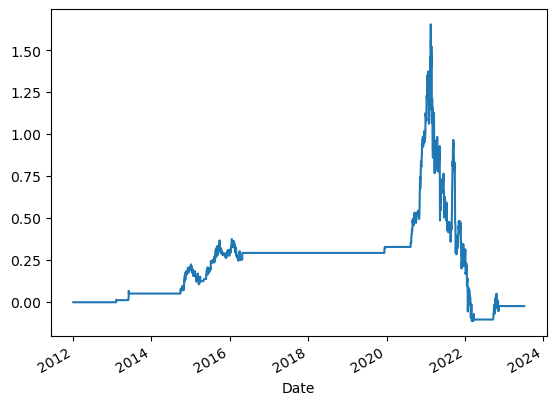

In [75]:
# Create a DataFrame with the signal (Z-scores) and position size (Actual spreads) in the pair
trades = pd.concat([zscore(spread), S2 - b * S1], axis=1)
trades.columns = ["signal", "position"]

# Add a long and short position at the z-score levels
trades["side"] = 0.0
trades.loc[trades.signal <= -1, "side"] = 1 # Any trades below signal, long on pair
trades.loc[trades.signal >= 1, "side"] = -1 # Any trades above signal, short on pair
# Any trades  in between signals = HOLD
returns = trades.position.pct_change() * trades.side # If % change is positive and you short it, you lose money as short trades profit when % change is negative
returns.cumsum().plot()

It seems this strategy has largely been profitable, especially during the Covid-19 era. This could be bcause Japan was an outlier during the COVID-19 pandemic, both in terms of government reactions to the crisis and the outcomes. It was the first G7 country to impose a travel ban and had not locked down country and borders. It also contained the spread of the virus well and experienced the least deaths, attributed to Japanese culture where people are accustomed to wearing face masks. The Japanese Yen was also resistant to shocks in the COVID-19 period.

The large spread during 2020 was firstly because the Yen held strong and experienced a trend of long term appreciation after the COVID pandemic, as it is a safe-haven currency where investors gravitate towards it and 2020 was a perfect example where investors held Yen in uncertain situations. This was just as the Nikkei fell from 24,000 to 16,500 by 31.25% just as the pandemic hit. 
The spread was later closed out when the Nikkei picked up in March 2020.